SmartRedis Library@18-46-06:WARNING: Environment variable SR_LOG_FILE is not set. Defaulting to stdout
SmartRedis Library@18-46-06:WARNING: Environment variable SR_LOG_LEVEL is not set. Defaulting to INFO
Input cell centers datasets available.
Input field datasets available.
Validation loss RMSE : 0.375604510307312
Epoch 1/500, Training Loss: 0.23908621072769165, Validation Loss: 0.14107874035835266
Validation loss RMSE : 0.3173421621322632
Epoch 2/500, Training Loss: 0.1651429682970047, Validation Loss: 0.1007060557603836
Validation loss RMSE : 0.2885448932647705
Epoch 3/500, Training Loss: 0.11823557317256927, Validation Loss: 0.08325815945863724
Validation loss RMSE : 0.3044525384902954
Epoch 4/500, Training Loss: 0.0940549373626709, Validation Loss: 0.0926913395524025
Validation loss RMSE : 0.3400910794734955
Epoch 5/500, Training Loss: 0.09569763392210007, Validation Loss: 0.11566194146871567
Validation loss RMSE : 0.334536075592041
Epoch 6/500, Training Loss: 0.11371835321187973,

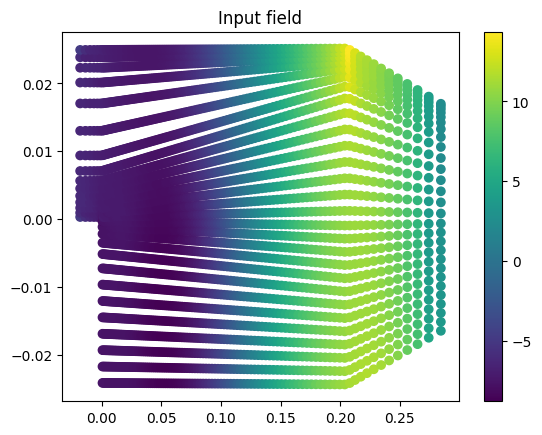

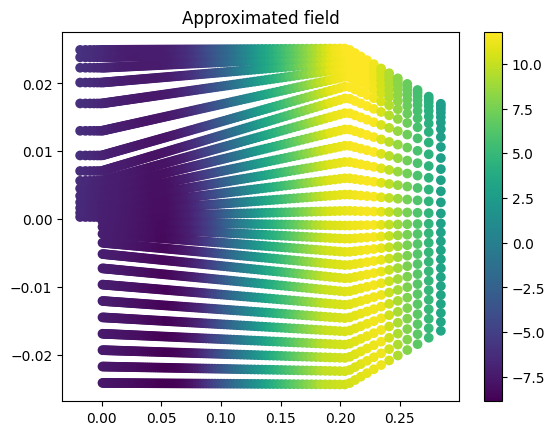

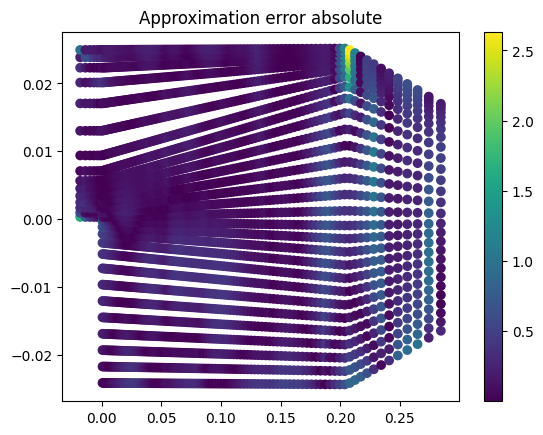

In [1]:
from smartsim import Experiment
from smartredis import Client
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import numpy as np
from matplotlib import pyplot as plt

class MLP(nn.Module):
    def __init__(self, num_layers, layer_width, input_size, output_size, activation_fn):
        super(MLP, self).__init__()

        layers = []
        layers.append(nn.Linear(input_size, layer_width))
        layers.append(activation_fn)

        for _ in range(num_layers - 2):
            layers.append(nn.Linear(layer_width, layer_width))
            layers.append(activation_fn)

        layers.append(nn.Linear(layer_width, output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

def sort_tensors_by_names(tensors, tensor_names):
    # Pair each tensor with its name and sort by the name
    pairs = sorted(zip(tensor_names, tensors))

    # Extract the sorted tensors
    tensor_names_sorted, tensors_sorted = zip(*pairs)

    # Convert back to list if needed
    tensor_names_sorted = list(tensor_names_sorted)
    tensors_sorted = list(tensors_sorted)

    return tensors_sorted, tensor_names_sorted


# Set up the execution of the foamSmartSimMapField application 
# as a SmartSim Experiment. 
exp = Experiment("foam-smartsim-map-fields", launcher="local")

db = exp.create_database(port=8000,       # database port
                         interface="lo")  # network interface to use
exp.start(db)

# Connect the python client to the smartredis database
client = Client(address=db.get_address()[0], cluster=False)

# Serial execution run settings for foamSmartSimMapFields
num_mpi_ranks = 1
run_settings_serial = exp.create_run_settings(exe="foamSmartSimMapFields", 
                                              exe_args="-inputCase pitzDailyCoarse -outputCase pitzDaily -field p")

# MPI parallel run settings for foamSmartSimMapFields - run_command can be "slurm" on a cluster.
# n_mpi_ranks = 4
# run_settings_parallel = exp.create_run_settings(exe="foamSmartSimMapFields", 
#                                                 exe_args="-inputCase pitzDailyCoarse -outputCase pitzDaily -field p -parallel", 
#                                                 run_command="mpirun", 
#                                                 run_args={"np": f"{num_mpi_ranks}"})

openfoam_mapfields_model = exp.create_model(name="foamSmartSimMapFields", run_settings=run_settings_serial)

try:
    # Run foamSmartSimMapFields and do not block
    exp.start(openfoam_mapfields_model, block=False)

    # Poll the cell centers in smartredis
    input_cell_centers_updated = client.poll_list_length("inputCentersDatasetList", 
                                                          num_mpi_ranks, 10, 1000);
    if (not input_cell_centers_updated):     
        raise ValueError("Input cell centers dataset list not available in smartredis.")
    else:
        print ("Input cell centers datasets available.")

    # Poll the input field in smartredis 
    input_field_updated = client.poll_list_length("inputFieldDatasetList", 
                                                  num_mpi_ranks, 10, 1000);
    if (not input_field_updated):     
        raise ValueError("Input field dataset list not available in smartredis.")
    else:
        print ("Input field datasets available.")

    # - Get the datasets
    input_centers_datasets = client.get_datasets_from_list("inputCentersDatasetList");  
    input_field_datasets = client.get_datasets_from_list("inputFieldDatasetList");

    # - Agglomerate all input data tensors from smartredis for the ML model training
    input_centers = []
    input_centers_names = []
    input_field = []
    input_field_names = []

    # Loop over all datasets that agglomerate input cell center tensors and input field tensors per MPI rank
    # and append the tensors to the global list of tensors along with their names. Sort the tensors w.r.t.
    # their names, i.e. w.r.t MPI rank to make sure that a cell center from an MPI rank corresponds to the 
    # right field data from the same MPI rank.
    for input_centers_dset, input_field_dset in zip(input_centers_datasets, input_field_datasets):
        input_centers_tensor_names = input_centers_dset.get_tensor_names()
        input_field_tensor_names = input_field_dset.get_tensor_names()
        for input_centers_name,input_field_name in zip(input_centers_tensor_names,input_field_tensor_names):
            
            input_centers.append(input_centers_dset.get_tensor(input_centers_name))
            input_centers_names.append(input_centers_name)
            
            input_field.append(input_field_dset.get_tensor(input_field_name))
            input_field_names.append(input_field_name)
            
    input_centers, input_center_names = sort_tensors_by_names(input_centers, input_centers_names)
    input_field, input_field_names = sort_tensors_by_names(input_field, input_field_names)
    
    # Flatten the training data
    input_field = torch.from_numpy(np.vstack(input_field)).float()
    input_centers = torch.from_numpy(np.vstack(input_centers)).float()

    # TODO(TM): hardcoded 2D dimensions, remove in a 3D simulation, adapt if 2D solution dimensions differ.'
    # FIXME(TM): use polyMesh::solutionD
    field_rank_found = client.poll_tensor("input_field_rank", 10, 1000)
    if (not field_rank_found):     
            raise ValueError("Input field rank not available in smartredis.")
    input_field_rank = client.get_tensor("input_field_rank")

    if (input_field_rank[0] > 0):
        input_field = input_field[:, :2]
    input_centers = input_centers[:, :2]

   

    # Train an ML model M(cell_center, theta), M: cell_center -> input_field
    # Split training and validation data
    field_train, field_val, centers_train, centers_val = train_test_split(input_field, input_centers, 
                                                                          test_size=0.2, random_state=42)

    # Fit the scaler on the training data
    target_scaler = MinMaxScaler().fit(field_train.numpy()) 
    
    # Transform the training and validation data
    field_train = torch.from_numpy(target_scaler.transform(field_train.numpy())).float()
    field_val = torch.from_numpy(target_scaler.transform(field_val.numpy())).float()

    # Initialize the model
    # TODO(TM): ML model should decide on the output rank based on the metadata sent by OpenFOAM.
    model = MLP(num_layers=5, layer_width=40, input_size=2, output_size=1, activation_fn=torch.nn.ReLU())

    # PYTORCH Training Loop
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_func = nn.MSELoss()
    epochs = 500
    mean_mag_displ = torch.mean(torch.norm(field_train, dim=1))
    for epoch in range(epochs):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass on the training data
        field_pred = model(centers_train)

        # Compute loss on the training data
        loss_train = loss_func(field_pred, field_train)

        # Backward pass and optimization
        loss_train.backward()
        optimizer.step()

        # Forward pass on the validation data, with torch.no_grad() for efficiency
        with torch.no_grad():
            field_pred_val = model(centers_val)
            loss_val = loss_func(field_pred_val, field_val)
            rmse_loss_val = torch.sqrt(loss_val)
            print (f'Validation loss RMSE : {rmse_loss_val}')
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {loss_train.item()}, Validation Loss: {loss_val.item()}')

    # Visualize the input field
    vis_centers = list(zip(*input_centers))
    if (input_field_rank[0] == 0):
        # TODO(TM): have OpenFOAM store a field name into a metadata dataset. 
        #           Get the input field name and use it in a title of the plot.
        plt.title("Input field")
        plt.scatter(vis_centers[0], vis_centers[1], c=input_field, cmap='viridis')
        plt.colorbar()
        
    # Visualize the ML approximation
    plt.figure()
    field_pred = model(input_centers)
    field_pred_np = torch.from_numpy(target_scaler.inverse_transform(field_pred.detach().numpy())).float()
    if (input_field_rank[0] == 0):
        # TODO(TM): have OpenFOAM store a field name into a metadata dataset. 
        #           Get the input field name and use it in a title of the plot.
        plt.title("Approximated field")
        plt.scatter(vis_centers[0], vis_centers[1], c=field_pred_np, cmap='viridis')
        plt.colorbar()

    # Visualize the approximation error
    approx_error = torch.abs(input_field - field_pred_np)
    plt.figure()
    if (input_field_rank[0] == 0):
        #TODO(TM): have OpenFOAM store a field name into a metadata dataset. 
        #          Get the input field name and use it in a title of the plot.
        plt.title("Approximation error absolute")
        plt.scatter(vis_centers[0], vis_centers[1], c=approx_error, cmap='viridis')
        plt.colorbar()

    # Perform forward inference of the model in smartredis using cell_centers as input and store output. 

    # Save the key in smartredis that forward pass has completed.

except Exception as e:
    print("Caught an exception: ", str(e))
    
finally:
    exp.stop(db)